# Universidad del Valle de Guatemala
## Security Data Science - 10
* Walter Danilo Saldaña Salguero - 19897
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 6: Clasificación de Malware con DL

Importamos librearias

In [1]:
import os, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

2023-05-01 14:25:45.436516: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 14:25:45.762629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 14:25:45.763600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 14:25:46.852332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Creamos el Dataset

In [2]:
from tabulate import tabulate

path = './malimg_paper_dataset_imgs/'

family_quantity = 0
ids = 0
columns = ['id', 'familyId', 'familyName', 'file', 'path', 'height', 'width']
data = []
for folder in os.listdir(path):
    if ('.txt' in folder): continue
    cont = 0
    full_path = path + folder + '/'
    for file in os.listdir(full_path):
        full_file_path = full_path + file
        img = cv2.imread(full_file_path, cv2.IMREAD_UNCHANGED)
        height, width = img.shape
        data.append([id, family_quantity, folder, file, full_file_path, height, width])
        cont += 1
        ids += 1
    print("Los ejemplares de la familia ", family_quantity, folder, " son\n", cont)
    family_quantity += 1
data = pd.DataFrame(data=data, columns=columns)

Los ejemplares de la familia  0 Adialer.C  son
 122
Los ejemplares de la familia  1 Agent.FYI  son
 116
Los ejemplares de la familia  2 Allaple.A  son
 2949
Los ejemplares de la familia  3 Allaple.L  son
 1591
Los ejemplares de la familia  4 Alueron.gen!J  son
 198
Los ejemplares de la familia  5 Autorun.K  son
 106
Los ejemplares de la familia  6 C2LOP.gen!g  son
 200
Los ejemplares de la familia  7 C2LOP.P  son
 146
Los ejemplares de la familia  8 Dialplatform.B  son
 177
Los ejemplares de la familia  9 Dontovo.A  son
 162
Los ejemplares de la familia  10 Fakerean  son
 381
Los ejemplares de la familia  11 Instantaccess  son
 431
Los ejemplares de la familia  12 Lolyda.AA1  son
 213
Los ejemplares de la familia  13 Lolyda.AA2  son
 184
Los ejemplares de la familia  14 Lolyda.AA3  son
 123
Los ejemplares de la familia  15 Lolyda.AT  son
 159
Los ejemplares de la familia  16 Malex.gen!J  son
 136
Los ejemplares de la familia  17 Obfuscator.AD  son
 142
Los ejemplares de la familia  18 

## Muestreo

Debido a que existe un gran desbalanceo entre los datos pertenecientes a las familias de malware, recurriremos a obtener una muestra de las familias con mayor data:
* Allaple.A: 2949 ejemplares
* Allaple.L: 1591 ejemplares
* Yuner.A: 800 ejemplares

Con ayuda de https://es.surveymonkey.com/mp/sample-size-calculator/ logramos obtener los siguientes tamaños de muestras con 0.95 de nivel de confianza y 0.0.5 de margen de error.

In [3]:
print("Los tamaños de muestra a trabajar para las familias son: ")
print("Allaple.A: 340 ejemplares")
print("Allaple.L: 310 ejemplares")
print("Yuner.A: 260 ejemplares")

Los tamaños de muestra a trabajar para las familias son: 
Allaple.A: 340 ejemplares
Allaple.L: 310 ejemplares
Yuner.A: 260 ejemplares


## Adquiriendo las muestras

In [4]:
df = pd.DataFrame(columns=columns)

for i in range(0, 26):
    temp_data = data[data['familyId'] == i]
    
    if i == 2:
        mask_a = data["familyId"] == 2
        temp_data = data[mask_a].sample(340)
    
    if i == 3:
        mask_l = data["familyId"] == 3
        temp_data = data[mask_l].sample(310)
    
    if i == 24:
        mask_yuner = data["familyId"] == 24
        temp_data = data[mask_yuner].sample(260)

    df = pd.concat([df, temp_data])
df

,id,familyId,familyName,file,path,height,width
0,<built-in function id>,0,Adialer.C,000bde2e9a94ba41c0c111ffd80647c2.png,./malimg_paper_dataset_imgs/Adialer.C/000bde2e...,410,512
1,<built-in function id>,0,Adialer.C,000e30a0819ac7ed931d629ce2ef8948.png,./malimg_paper_dataset_imgs/Adialer.C/000e30a0...,409,512
2,<built-in function id>,0,Adialer.C,002f06eff1d222560939be72583d6ae9.png,./malimg_paper_dataset_imgs/Adialer.C/002f06ef...,410,512
3,<built-in function id>,0,Adialer.C,0044f0746b812f6b454ce210bc58c572.png,./malimg_paper_dataset_imgs/Adialer.C/0044f074...,410,512
4,<built-in function id>,0,Adialer.C,0046a83d932a3d431eb21a99b46d6af7.png,./malimg_paper_dataset_imgs/Adialer.C/0046a83d...,409,512
...,...,...,...,...,...,...,...
8978,<built-in function id>,24,Yuner.A,040c49b5b9e2c413f936c970c886a039.png,./malimg_paper_dataset_imgs/Yuner.A/040c49b5b9...,683,768
9074,<built-in function id>,24,Yuner.A,05417c48fd94b9a0fe2a0442c0f37ddf.png,./malimg_paper_dataset_imgs/Yuner.A/05417c48fd...,683,768
9006,<built-in function id>,24,Yuner.A,046a69a7fe7c6340665cec1df664910c.png,./malimg_paper_dataset_imgs/Yuner.A/046a69a7fe...,683,768
8785,<built-in function id>,24,Yuner.A,00f6087c49eb1f4f4bdabbc37e292370.png,./malimg_paper_dataset_imgs/Yuner.A/00f6087c49...,683,768


Comprobamos que si se haya obtenido la cantidad de muestras de cada familia

In [5]:
print("Allaple.A", len(df[df['familyId'] == 2]))
print("Allaple.L", len(df[df['familyId'] == 3]))
print("Yuner.A", len(df[df['familyId'] == 24]))

Allaple.A 340
Allaple.L 310
Yuner.A 260


Obtenemos el csv

In [6]:
df.to_csv('./data_imgs_malware.csv', index=False, encoding='utf8')

# Analisis Exploratorio

In [2]:
df = pd.read_csv('./data_imgs_malware.csv', encoding='utf8')

In [4]:
df.sample(10)

,id,familyId,familyName,file,path,height,width
3871,<built-in function id>,19,Skintrim.N,00de89edcd15db35e4d8a781e128879c.png,./malimg_paper_dataset_imgs/Skintrim.N/00de89e...,509,384
1085,<built-in function id>,4,Alueron.gen!J,08add37e48066301bcfcb4ecf9e73cae.png,./malimg_paper_dataset_imgs/Alueron.gen!J/08ad...,368,256
4145,<built-in function id>,22,VB.AT,000386761524b7b36f065fdb69365dca.png,./malimg_paper_dataset_imgs/VB.AT/000386761524...,895,512
1,<built-in function id>,0,Adialer.C,000e30a0819ac7ed931d629ce2ef8948.png,./malimg_paper_dataset_imgs/Adialer.C/000e30a0...,409,512
347,<built-in function id>,2,Allaple.A,050a60ff590dd10863290c0af964b9de.png,./malimg_paper_dataset_imgs/Allaple.A/050a60ff...,334,256
4595,<built-in function id>,23,Wintrim.BX,007a54dcd7665cef70d314381c0a22ca.png,./malimg_paper_dataset_imgs/Wintrim.BX/007a54d...,623,512
2944,<built-in function id>,13,Lolyda.AA2,0044d41a4db187677a849be084dc43b5.png,./malimg_paper_dataset_imgs/Lolyda.AA2/0044d41...,288,128
3499,<built-in function id>,16,Malex.gen!J,0879fffc105d679cde28d045b64354a5.png,./malimg_paper_dataset_imgs/Malex.gen!J/0879ff...,322,256
1360,<built-in function id>,6,C2LOP.gen!g,073a8d77322d78f5771e2b8b1708e73b.png,./malimg_paper_dataset_imgs/C2LOP.gen!g/073a8d...,937,512
373,<built-in function id>,2,Allaple.A,000aae69a2d0ea19c2e7d1ed5bda99d3.png,./malimg_paper_dataset_imgs/Allaple.A/000aae69...,264,256


### Datos estadisticos

In [5]:
df.describe()

,familyId,height,width
count,4909.000000,4909.000000,4909.000000
mean,11.709717,487.457731,381.796700
std,7.159314,237.244718,231.194613
min,0.000000,208.000000,64.000000
25%,6.000000,306.000000,128.000000
50%,11.000000,445.000000,384.000000
75%,18.000000,639.000000,512.000000
max,24.000000,5334.000000,1024.000000


In [3]:
DIMENSION = 100
IMG_SIZE = (DIMENSION, DIMENSION)

def getImages(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    return np.asarray(image, dtype='float32')

df['image'] = df['path'].apply(getImages)
df['image'].head()

0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [40.0, 40.0, 40.0], [50.0, ...
2    [[[0.0, 0.0, 0.0], [39.0, 39.0, 39.0], [50.0, ...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: image, dtype: object

# Imagenes

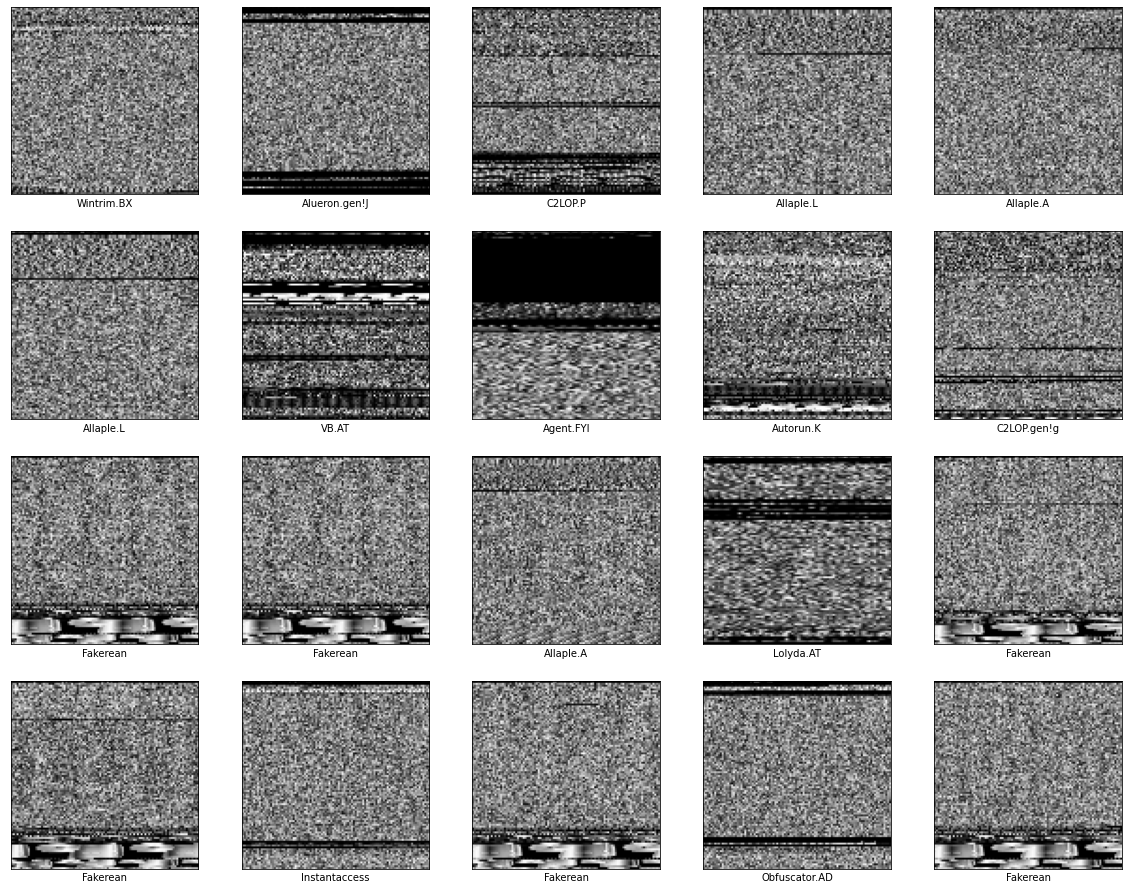

In [7]:
to_show = df.sample(20)

fig_size = (20, 20)
fig = plt.figure(figsize=fig_size)

id = 0
for index, row in to_show.iterrows():
    plt.subplot(5, 5, id + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row['image'].astype(np.uint8))
    plt.xlabel(row['familyName'])
    id += 1

plt.show()

In [79]:
X_train, X_test, _y_train, _y_test = train_test_split(df['image'], df['familyId'], test_size=0.3, random_state=42)

X_train = np.array(list(X_train))
X_test = np.array(list(X_test))
y_train = list(_y_train)
y_test = list(_y_test)

temp_y_train = []
for i in range(len(y_train)):
    temp = [0 for _ in range(25)]
    temp[y_train[i]] = 1
    temp_y_train.append(temp)
    
temp_y_test = []
for i in range(len(y_test)):
    temp = [0 for _ in range(25)]
    temp[y_test[i]] = 1
    temp_y_test.append(temp)

y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)

# convert numpy arrays to tensors
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [80]:
# Se limita el nivel de log de tensorflow para reducir la carga de procesamiento
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [81]:
'''from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Conv2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(DIMENSION, DIMENSION, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(4064, activation='relu'))
model.add(Dense(1016, activation='sigmoid'))
model.add(Dense(508, activation='relu'))
model.add(Dense(254, activation='relu'))
model.add(Dense(25, activation='sigmoid'))'''
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(25, activation='relu'))
#model.add(Dense(25, activation='softmax'))


print('input shape', model.input_shape)
print('output shape', model.output_shape)

input shape (None, 100, 100, 3)
output shape (None, 25)


In [82]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_25 (Dense)            (None, 256)               8388864   
                                                                 
 dense_26 (Dense)            (None, 25)                6425      
                                                                 
Total params: 31,983,001
Trainable params: 31,929,881
Non-trainable params: 53,120
_________________________________________________________________


In [83]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [84]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
108/108 [==============================] - 252s 2s/step - loss: nan - accuracy: 0.1476
Epoch 2/10
108/108 [==============================] - 223s 2s/step - loss: nan - accuracy: 0.0239
Epoch 3/10
108/108 [==============================] - 222s 2s/step - loss: nan - accuracy: 0.0239
Epoch 4/10
108/108 [==============================] - 246s 2s/step - loss: nan - accuracy: 0.0239
Epoch 5/10
108/108 [==============================] - 250s 2s/step - loss: nan - accuracy: 0.0239
Epoch 6/10
108/108 [==============================] - 249s 2s/step - loss: nan - accuracy: 0.0239
Epoch 7/10
108/108 [==============================] - 258s 2s/step - loss: nan - accuracy: 0.0239
Epoch 8/10
108/108 [==============================] - 252s 2s/step - loss: nan - accuracy: 0.0239
Epoch 9/10
108/108 [==============================] - 254s 2s/step - loss: nan - accuracy: 0.0239
Epoch 10/10
108/108 [==============================] - 226s 2s/step - loss: nan - accuracy: 0.0239


In [74]:
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

47/47 [==============================] - 18s 362ms/step


In [78]:
y_pred

array([[9.49917454e-03, 3.02465618e-01, 4.07608151e-02, ...,
        1.21442914e-01, 1.05738500e-02, 1.83313526e-02],
       [1.09404055e-02, 1.40429169e-01, 5.50731122e-02, ...,
        1.01317517e-01, 8.16663727e-03, 1.58376638e-02],
       [1.09036677e-02, 8.73746276e-02, 6.49913996e-02, ...,
        8.37754160e-02, 8.09065253e-03, 1.09023787e-02],
       ...,
       [9.18905309e-04, 4.03331267e-03, 3.96098476e-03, ...,
        2.14558770e-03, 1.31179031e-03, 1.20205141e-03],
       [1.48178739e-02, 1.14013948e-01, 6.81847557e-02, ...,
        9.72327068e-02, 8.14183708e-03, 1.40540814e-02],
       [1.24176455e-04, 1.68925399e-04, 4.80226532e-04, ...,
        4.63190772e-05, 1.38358271e-04, 1.20542958e-04]], dtype=float32)

In [77]:
accuracy = accuracy_score(y_pred_classes, y_test)
precision = precision_score(y_pred_classes, y_test, average='weighted')
recall = recall_score(y_pred_classes, y_test, average='weighted')
f1 = f1_score(y_pred_classes, y_test, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Accuracy:  0.09775967413441955
Precision:  0.9910677257791815
Recall:  0.19753086419753085
F1:  0.3015346017206325


/home/walt/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


En este caso notamos métricas bastante pobres, a excepción de la precisión con un valor del 100%, sin embargo al revisar los valores predichos, se observa que todos son "1", por lo que es de esperarse que la precisión sea perfecta, pero no implica que el modelo este entrenado correctamente.

Prueba con otro modelo para mejorar resultados

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

In [27]:
train_df, test_df = train_test_split(df, test_size=0.3)

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    x_col='path', 
                                                    y_col='familyName', 
                                                    target_size=(100, 100), 
                                                    batch_size=32, 
                                                    class_mode='categorical', 
                                                    subset='training')
valid_generator = train_datagen.flow_from_dataframe(dataframe=test_df, 
                                                    x_col='path', 
                                                    y_col='familyName', 
                                                    target_size=(100, 100), 
                                                    batch_size=32, 
                                                    class_mode='categorical', 
                                                    subset='validation')


Found 2406 validated image filenames belonging to 25 classes.
Found 441 validated image filenames belonging to 25 classes.


In [29]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10


2023-04-30 22:21:26.495732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - ETA: 0s - loss: 2.0617 - accuracy: 0.6858

2023-04-30 22:24:07.733610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - 167s 2s/step - loss: 2.0617 - accuracy: 0.6858 - val_loss: 25343.4375 - val_accuracy: 0.0930
Epoch 2/10
76/76 [==============================] - 158s 2s/step - loss: 0.5389 - accuracy: 0.8761 - val_loss: 52.1154 - val_accuracy: 0.0317
Epoch 3/10
76/76 [==============================] - 157s 2s/step - loss: 0.5547 - accuracy: 0.9177 - val_loss: 28.7578 - val_accuracy: 0.0227
Epoch 4/10
76/76 [==============================] - 159s 2s/step - loss: 0.7514 - accuracy: 0.9090 - val_loss: 2400.1694 - val_accuracy: 0.0930
Epoch 5/10
76/76 [==============================] - 157s 2s/step - loss: 0.5603 - accuracy: 0.9298 - val_loss: 5.1183 - val_accuracy: 0.1179
Epoch 6/10
76/76 [==============================] - 159s 2s/step - loss: 0.3793 - accuracy: 0.9385 - val_loss: 5.5317 - val_accuracy: 0.0544
Epoch 7/10
76/76 [==============================] - 160s 2s/step - loss: 0.2952 - accuracy: 0.9551 - val_loss: 18.0336 - val_accuracy: 0.0635
Epoch 8/10
76/

In [32]:
loss, accuracy = model.evaluate_generator(valid_generator)
print(f'Validation accuracy: {accuracy}')

/tmp/ipykernel_17907/1616659391.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(valid_generator)
2023-04-30 22:48:01.505300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation accuracy: 0.022675737738609314


In [33]:
from sklearn.metrics import classification_report
y_true = test_df['familyName']
y_pred = model.predict_generator(valid_generator).argmax(axis=-1)
print(classification_report(y_true, y_pred))

/tmp/ipykernel_17907/99167293.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(valid_generator).argmax(axis=-1)
2023-04-30 22:48:06.810313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


ValueError: Found input variables with inconsistent numbers of samples: [1473, 441]